In [5]:
import chaospy

In [1]:
import jax

jax.config.update("jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np

import functools
from jax.typing import ArrayLike
from jax import Array
import time

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools
from matplotlib.gridspec import GridSpec

In [3]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from uq_methods import monte_carlo

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

## uncertainity propagation using AD

Suppose there is a function $f$ which maps input parameters ($x_0, x_1, ..., x_n$) to output parameters ($y_0, y_1, .. , y_m$)

$f : \mathbb{R}^{n}\to \mathbb{R}^{m}$

The covariance matrix for input parameters is given as

$\boldsymbol{C}_{xx}$

where each entry of covariance matrix is given as

$C_{ij} = \text{cov}[x_i, x_j]$ 

where cov[$x_i, x_j$] is the covariance between the input parameters $x_i, x_j$.

The Covariance matrix for the output values is then given as 

$\boldsymbol{C}_{yy} = \boldsymbol{J}_{yx} \boldsymbol{C}_{xx} \boldsymbol{J}_{yx}^\text{T}$

where $\boldsymbol{J}_{yx}$ is the sensitivity matrix where each entry is defined as

$J_{y_i x_j} = \dfrac{\partial y_i}{\partial x_j}$

Here we use automatic differentiation to compute this sensitivity matrix. 

In [4]:
def setup(N, vf):
    H, L = (N, N)
    r = jnp.sqrt(vf*N*N)
    r = r.astype(int)
    
    #r = int(N / 3)

    structure = jnp.zeros((H, L))
    rectangle = jnp.ones((r, r))
    structure = structure.at[:r, -r:].set(1)
    #structure = jax.lax.dynamic_slice_in_dim(structure, rectangle, r, axis=0)

    return structure

In [5]:
structure = setup(127, vf=1/9)

In [6]:
N = structure.shape[0]
ndim = len(structure.shape)

# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor

In [7]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

In [8]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="rotated", length=1.0)

In [9]:
@jax.jit
def param(X, soft, hard):
    return soft * jnp.ones_like(X) * (X) + hard * jnp.ones_like(X) * (1 - X)

In [10]:
# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)


@jax.jit
def green_lagrange_strain(F: ArrayLike) -> Array:
    return 0.5 * (tensor.dot22(tensor.trans2(F), F) - I)

In [11]:
@jax.jit
def strain_energy(F, props):

    # material parameters
    elastic_modulus = {"hard": props.at[0].get(), "soft": props.at[2].get()}  # N/mm2
    poisson_modulus = {"hard": props.at[1].get(), "soft": props.at[3].get()}

    # lames constant
    lambda_modulus = {}
    shear_modulus = {}
    bulk_modulus = {}

    key = "hard"
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

    key = "soft"
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

    # material parameters
    μ0 = param(
        structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
    )  # shear     modulus
    λ0 = param(
        structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
    )  # shear     modulus

    E = green_lagrange_strain(F)
    E = 0.5 * (E + tensor.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(E) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(E, E))
    )
    return energy.sum()


piola_kirchhoff = jax.jit(jax.jacrev(strain_energy, argnums=0))

In [12]:
@jax.jit
def G_P(dF, additional):
    F, props = additional
    dF = dF.reshape(ndim, ndim, N, N)
    tangents = jax.jvp(piola_kirchhoff, (F, props), (dF, jnp.zeros_like(props)))[1]
    return G(tangents)

In [13]:
@jax.jit
def scan_conjugate_gradient(state, n):
    x, b, F, Fn, props, r, p, rsold, iiter, cg_tol = state
    x, b, props, r, p, rsold = jax.device_put((x, b, props, r, p, rsold))

    error = jnp.sqrt(rsold)
    # jax.debug.print('CG residual = {}', error)

    def true_fun(state):
        x, b, F, Fn, props, r, p, rsold, iiter, cg_tol = state

        Ap = G_P(p, (F, props))
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter = iiter + 1
        return (x, b, F, Fn, props, r, p, rsold, iiter, cg_tol)

    def false_fun(state):
        return state

    return jax.lax.cond(error > cg_tol, true_fun, false_fun, state), n


@jax.jit
def scan_newton_raphson(state, n):
    # jax.debug.print('NR loop')
    dF, b, F, Fn, props, r, p, rsold, iiter, cg_tol = state

    error = jnp.linalg.norm(dF) / Fn

    # jax.debug.print('NR residual={}', error)

    def true_fun(state):
        dF, b, F, Fn, props, r, p, rsold, iiter, cg_tol = state

        x = jnp.zeros_like(b)
        r = b - G_P(x, (F, props))
        p = r
        rsold = jnp.vdot(r, r)

        state = (x, b, F, Fn, props, r, p, rsold, iiter, cg_tol)

        state, xs = jax.lax.scan(
            scan_conjugate_gradient, init=state, xs=jnp.arange(0, 10)
        )

        dF, b, F, Fn, props, r, p, rsold, iiter, cg_tol = state

        dF = dF.reshape(ndim, ndim, N, N)
        F = jax.lax.add(F, dF)  # update DOFs (array -> tensor.grid)
        P = piola_kirchhoff(F, props)  # new residual stress
        b = -G(P)  # compute residual

        return (dF.reshape(-1), b, F, Fn, props, r, p, rsold, iiter, cg_tol)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-8, true_fun, false_fun, state), n

We want to quantify the uncertainity in the strain energy of the system due to variation in the material properties of the inclusion and the matrix. 

We assume a `normal distribution` of the properties with the mean and standard deviation in the properties of the inclusion and the matrix is given as 

|   | $v_f$    | $E_{inc}$   |  $\nu_{inc}$      | $E_{mat}$ |  $\nu_{mat}$  |
|---|-----|--|--------|---------------|------------|
| $\mu$  | 0.55 |  5.7  | 0.386     |     0.57     |     0.386        |
| $\sigma$ | 0.034  | 0.02  |  0.01     |     0.04     |      -        |


In [38]:
mean_values = [5.7, 0.386, 0.57, 0.386]
std_deviations = [0.1, 0.03, 0.01, 0.03]

In [39]:
@jax.jit
def compute_objective(props):
    loading = 0.1

    # set macroscopic loading
    DbarF = jnp.zeros([ndim, ndim, N, N])
    DbarF = DbarF.at[0, 1].add(loading)

    # initial residual: distribute "barF" over grid using "K"
    F = jnp.array(I, copy=True)

    b = -G_P(DbarF, (F, props))
    F = jax.lax.add(F, DbarF)
    Fn = jnp.linalg.norm(F)
    # starting the monitoring

    DbarF = DbarF.reshape(-1)
    r = jnp.zeros_like(b)
    p = jnp.zeros_like(b)
    rsold = 0.0
    iiter = 0.0
    cg_tol = 1e-10

    state = (DbarF, b, F, Fn, props, r, p, rsold, iiter, cg_tol)
    state = jax.device_put(state)

    final_state, xs = jax.lax.scan(
        scan_newton_raphson, init=state, xs=jnp.arange(0, 10)
    )

    energy = strain_energy(final_state[2], props)

    return energy , energy

In [40]:
# each column is the sensitivity vector of each prop
compute_sensitivity = jax.jit(jax.jacrev(compute_objective, has_aux=True))

In [41]:
props = jnp.array(mean_values)

In [42]:
df_dx, energy = compute_sensitivity(props)

In [43]:
d2f_dx2 = jax.jit(jax.hessian(compute_objective, has_aux=True))

In [83]:
%timeit -n1 -r1 -o d2f_dx2(props)

20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [44]:
d2f_dx2_fwd_rev = jax.jit(jax.jacfwd(jax.jacrev(compute_objective, has_aux=True), has_aux=True))

In [45]:
d2f_dx2, energy = d2f_dx2_fwd_rev(props)

In [103]:
d2f_dx2.shape

(4, 4)

In [84]:
%timeit -n1 -r1 -o d2f_dx2_fwd_rev(props)

20.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 20.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [90]:
d2f_dx2_rev_fwd = jax.jit(jax.jacrev(jax.jacfwd(compute_objective, has_aux=True), has_aux=True))

In [91]:
%timeit -n1 -r1 -o d2f_dx2_rev_fwd(props)

1min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 1min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [34]:
d2f_dx2_rev_rev = jax.jit(jax.jacrev(jax.jacrev(compute_objective, has_aux=True), has_aux=True))

In [85]:
%timeit -n1 -r1 -o d2f_dx2_rev_rev(props)

23.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 23.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [36]:
d2f_dx2_fwd_fwd = jax.jit(jax.jacfwd(jax.jacfwd(compute_objective, has_aux=True), has_aux=True))

In [86]:
%timeit -n1 -r1 -o d2f_dx2_fwd_fwd(props)

54.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 54.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

## Monte-carlo simulations
Now we run Monte-Carlo simulations to analyze the computational time and accuracy of the standard deviations.

We start with generating various relations of properties from a random normal distribution. 


In [46]:
nb_realizations = 600
random_variables = np.zeros((nb_realizations, len(mean_values)))
np.random.seed(2)

for i in range(len(mean_values)):
    random_variables[:, i] = np.random.normal(
        loc=mean_values[i], scale=std_deviations[i], size=nb_realizations
    )[:]

In [47]:
monte_carlo_wrapper = monte_carlo(random_variables=random_variables, has_aux=True)
outputs, aux = monte_carlo_wrapper(compute_objective)()

In [95]:
%timeit -n1 -r1 -o monte_carlo_wrapper(compute_objective)()

6min 56s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 6min 56s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [48]:
np.std(outputs)

2.3238709368211534

In [49]:
np.mean(outputs)

126.73641493926795

In [50]:
cum_std_mc = [np.std(outputs[:i]) for i in range(10, nb_realizations - 1)]
cum_mean_mc = [np.mean(outputs[:i]) for i in range(10, nb_realizations - 1)]

In [51]:
Cov = np.cov(random_variables.T)
np.sqrt(np.dot(df_dx, Cov @ df_dx))

2.3368071059791076

In [53]:
energy + 0.5*np.einsum('ij, ij->', Cov, d2f_dx2)

Array(126.80126831, dtype=float64)

In [54]:
cum_std_ad = [
    np.sqrt(np.dot(df_dx, np.cov(random_variables[:i, :].T) @ df_dx))
    for i in range(10, nb_realizations - 1)
]

In [55]:
cum_mean_ad = [
    energy + 0.5*np.einsum('ij, ij->', np.cov(random_variables[:i, :].T), d2f_dx2)
    for i in range(10, nb_realizations - 1)
]

In [64]:
import matplotlib.gridspec as gridspec
from matplotlib import ticker

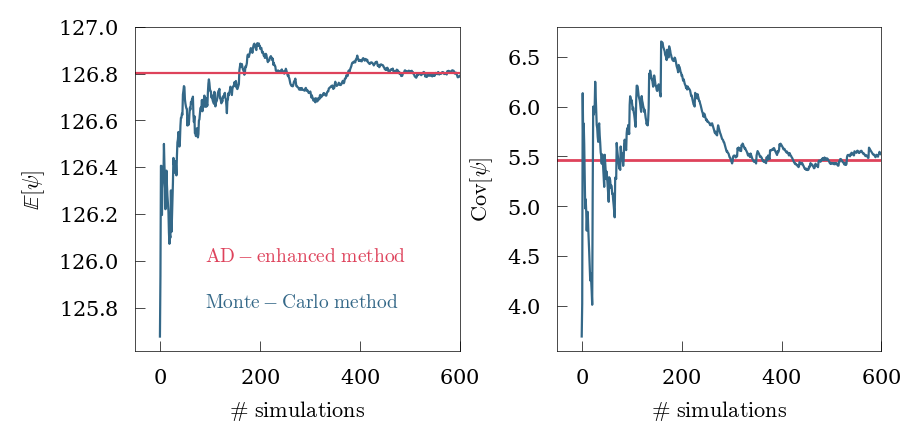

In [76]:
fig = plt.figure(
    figsize=set_size(width="two-column", fraction=0.975, height_ratio=0.35),
    constrained_layout=False,
    dpi=200,
)
gs1 = gridspec.GridSpec(1, 2, figure=fig,  left=0.01, right=0.55, top=0.98, bottom=0.00)
gs1.update(wspace=0.3) 

colors  ={'ad' : '#de425b', 'mc' :  '#346888' }

ax = fig.add_subplot(gs1[:, 0])
ax.plot(cum_mean_mc, color=colors['mc'], lw=0.8)
ax.axhline(energy + 0.5*np.einsum('ij, ij->', Cov, d2f_dx2), color=colors['ad'], lw=0.8)

ax.set_xlabel(r"$\# \mathrm{~simulations}$")
ax.set_ylabel(r"$\mathbb{E}[\psi]$")
ax.set_ylim(top=127)
ax.set_xlim(right=600)
ax.set_aspect(1/ax.get_data_ratio())

ax.text(90, 126, r"$\mathrm{AD-enhanced~method}$", fontsize=7, color=colors['ad'])
ax.text(90, 125.8, r"$\mathrm{Monte}-\mathrm{Carlo~method}$", fontsize=7, color=colors['mc'])


ax = fig.add_subplot(gs1[:, 1])

ax.plot(np.asarray(cum_std_mc)**2, color=colors['mc'], lw=0.8)
ax.axhline(np.dot(df_dx, Cov@df_dx), color=colors['ad'], zorder=-1)
ax.set_xlabel(r"$\# \mathrm{~simulations}$")
ax.set_ylabel(r"$\text{Cov}[\psi]$")
ax.set_xlim(right=600)

ax.set_aspect(1/ax.get_data_ratio())
plt.savefig('./figs/paper_uq.svg')
plt.show()